mcu data: https://www.kaggle.com/pdunton/marvel-cinematic-universe-dialogue?select=mcu_subset.csv


dataset: https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [343]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, RegexTokenizer, PCA, IndexToString, StringIndexer, VectorIndexer
from pyspark.mllib.regression import LabeledPoint
from IPython.display import Image
from pyspark.sql import SparkSession
import IPython
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
from sklearn.naive_bayes import GaussianNB
import time

In [344]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark
spark = init_spark()

# 1. Data Preparation

![display image](https://media.giphy.com/media/3oxHQjRHcp4w9oi24M/giphy.gif)

In [345]:
read_csv = spark.read.csv('data/Twitter_Data_utf8.csv', inferSchema=True, header=True)

In [346]:
data = read_csv.select("clean_text", col("category").cast("Int").alias("label")).dropna().dropDuplicates().replace(-1,2).orderBy(rand()).limit(140000)

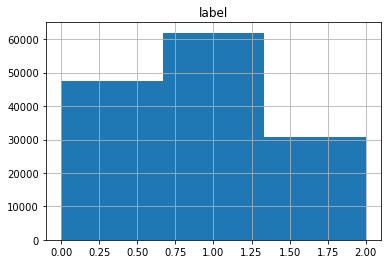

In [347]:
data_p = data.drop('clean_text').toPandas()
hist = data_p.hist(bins=3)

In [348]:

split = data.randomSplit([0.7, 0.3])
trainingData = split[0]
testingData = split[1]
print ("Training data has", split[0].count(), 'rows.')
print ("Testing data has", split[1].count(), 'rows.')

Training data has 97876 rows.
Testing data has 42124 rows.


### Cleaning The Data (Tokenizing and Stop Word Removing)

In [349]:
stopwordList = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [350]:
stopwordList.extend(StopWordsRemover().getStopWords())


In [351]:
#inputCol = "SentimentText"
inputCol = "clean_text"

tokenizer = RegexTokenizer(pattern=r'(?:\p{Punct}|\s)+', inputCol=inputCol, outputCol="Tokens")
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="NoStopWords", stopWords=stopwordList)

token_train = tokenizer.transform(trainingData)
nosw_train = swr.transform(token_train)

token_test = tokenizer.transform(testingData)
nosw_test = swr.transform(token_test)

nosw_train.show(truncate=True, n=10)
nosw_test.show(truncate=True, n=10)

+--------------------+-----+--------------------+--------------------+
|          clean_text|label|              Tokens|         NoStopWords|
+--------------------+-----+--------------------+--------------------+
|                    |    0|                  []|                  []|
|     fan opens mo...|    0|[fan, opens, modi...|[fan, opens, modi...|
|                   "|    1|                  []|                  []|
|   any idea what ...|    1|[any, idea, what,...|[idea, yrs, rule,...|
|   can finally re...|    0|[can, finally, re...|[finally, read, m...|
|   dont pappu  mo...|    1|[dont, pappu, mod...|[dont, pappu, mod...|
|  all the best de...|    1|[all, the, best, ...|[best, dear, brot...|
|  and other oppos...|    1|[and, other, oppo...|[opposition, part...|
|    great distress "|    1|   [great, distress]|   [great, distress]|
|  india mein nahi...|    2|[india, mein, nah...|[india, mein, nah...|
+--------------------+-----+--------------------+--------------------+
only s

### Hashing The Features using HashingTF

In [352]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
hash_train = hashTF.transform(nosw_train).select(
    'label', 'Tokens', 'features')

hash_test = hashTF.transform(nosw_test).select(
    'label', 'Tokens', 'features')
hash_train.show(n=5)
hash_test.show(n=5)

+-----+--------------------+--------------------+
|label|              Tokens|            features|
+-----+--------------------+--------------------+
|    0|                  []|      (262144,[],[])|
|    0|[fan, opens, modi...|(262144,[18911,72...|
|    1|                  []|      (262144,[],[])|
|    1|[any, idea, what,...|(262144,[30020,31...|
|    0|[can, finally, re...|(262144,[7625,409...|
+-----+--------------------+--------------------+
only showing top 5 rows

+-----+--------------------+--------------------+
|label|              Tokens|            features|
+-----+--------------------+--------------------+
|    1|                  []|      (262144,[],[])|
|    0|[please, please, ...|(262144,[49918,16...|
|    1|[modi, invested, ...|(262144,[2284,409...|
|    0|                  []|      (262144,[],[])|
|    1|                  []|      (262144,[],[])|
+-----+--------------------+--------------------+
only showing top 5 rows



### Adding weights

In [353]:
train_size = hash_train.count()
ratios = hash_train.groupBy('label').count()
ratios.show()
pos_ratio = (ratios.collect()[0][1])/train_size
neg_ratio = (ratios.collect()[1][1])/train_size 
neut_ratio = (ratios.collect()[2][1])/train_size 

train=hash_train.withColumn("classWeights", when(hash_train.label == 1,1-pos_ratio-neut_ratio).when(hash_train.label == 2,pos_ratio).otherwise(neut_ratio))
train.show(10)

+-----+-----+
|label|count|
+-----+-----+
|    0|33056|
|    1|43227|
|    2|21593|
+-----+-----+

+-----+--------------------+--------------------+-------------------+
|label|              Tokens|            features|       classWeights|
+-----+--------------------+--------------------+-------------------+
|    0|                  []|      (262144,[],[])|0.22061588131922025|
|    0|[fan, opens, modi...|(262144,[18911,72...|0.22061588131922025|
|    1|                  []|      (262144,[],[])|0.44165066001879927|
|    1|[any, idea, what,...|(262144,[30020,31...|0.44165066001879927|
|    0|[can, finally, re...|(262144,[7625,409...|0.22061588131922025|
|    1|[dont, pappu, mod...|(262144,[40963,45...|0.44165066001879927|
|    1|[all, the, best, ...|(262144,[40963,49...|0.44165066001879927|
|    1|[and, other, oppo...|(262144,[6801,394...|0.44165066001879927|
|    1|   [great, distress]|(262144,[80393,26...|0.44165066001879927|
|    2|[india, mein, nah...|(262144,[12650,29...|0.3377334586

# 2. Training 

![display image](https://media.giphy.com/media/dfJ0ns8LBXNni/giphy.gif)

In [354]:
#mlor = LogisticRegression(weightCol = "classWeights", family = 'multinomial')
mlor = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

In [355]:
ovr = OneVsRest(classifier=mlor)

In [356]:
start = time.time()
#model= mlor.fit(train)
model = ovr.fit(train)
end = time.time()
print('Training done in '+str(end - start)+' seconds.')

Training done in 19.120157718658447 seconds.


In [357]:
predictionss = model.transform(hash_test)
#prediction.show(5)

### Accuracy model

In [358]:
predictionFinal = predictionss.select("prediction", "label")
predictionFinal.show(n=5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    1|
+----------+-----+
only showing top 5 rows



In [359]:
# match = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['label']).count()
# total = predictionFinal.count()
# print("Accuracy:", match/total)

In [360]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
temp = predictionFinal.drop('Tokens')
# get metrics
f1 = evaluatorMulti.evaluate(temp, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(temp, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(temp, {evaluatorMulti.metricName: "weightedRecall"})
accuracy = evaluatorMulti.evaluate(predictionss)


print("Summary Stats")
print("Accuracy = %s " % accuracy)
print("Precision = %s" % weightedPrecision)
print("Recall = %s" % weightedRecall)
print("F1 Score = %s" % f1)

Summary Stats
Accuracy = 0.7546576316170315 
Precision = 0.75562088330665
Recall = 0.7546291900104454
F1 Score = 0.7546576316170315


# 3. Applying model to MCU Scripts

![display image](https://media.giphy.com/media/j2pWZpr5RlpCodOB0d/giphy.gif)

In [361]:
mcu_csv = spark.read.csv('data/mcu_subset.csv', inferSchema=True, header=True)
print("Lines of Dialogue:", mcu_csv.count())

Lines of Dialogue: 6509


In [362]:
mcu_data = mcu_csv.select("character","line", "movie")
mcu_data.show(n=5)

+----------+--------------------+--------+
| character|                line|   movie|
+----------+--------------------+--------+
|TONY STARK|Oh, I get it.  Yo...|Iron Man|
|TONY STARK|Oh.  I see.  So i...|Iron Man|
|TONY STARK|Good God, you’re ...|Iron Man|
|TONY STARK|             Please.|Iron Man|
|TONY STARK|Excellent questio...|Iron Man|
+----------+--------------------+--------+
only showing top 5 rows



In [363]:
t = Tokenizer(inputCol="line", outputCol="new_line")
swr_MCU = StopWordsRemover(inputCol=t.getOutputCol(), 
                       outputCol="new", stopWords=stopwordList)
token_MCU = t.transform(mcu_data)
nosw_MCU = swr_MCU.transform(token_MCU)
nosw_MCU.show(n=5)


+----------+--------------------+--------+--------------------+--------------------+
| character|                line|   movie|            new_line|                 new|
+----------+--------------------+--------+--------------------+--------------------+
|TONY STARK|Oh, I get it.  Yo...|Iron Man|[oh,, i, get, it....|[oh,, get, it., ,...|
|TONY STARK|Oh.  I see.  So i...|Iron Man|[oh., , i, see., ...|[oh., , see., , i...|
|TONY STARK|Good God, you’re ...|Iron Man|[good, god,, you’...|[good, god,, you’...|
|TONY STARK|             Please.|Iron Man|           [please.]|           [please.]|
|TONY STARK|Excellent questio...|Iron Man|[excellent, quest...|[excellent, quest...|
+----------+--------------------+--------+--------------------+--------------------+
only showing top 5 rows



In [364]:
hashTF = HashingTF(inputCol=swr_MCU.getOutputCol(), outputCol="features")
hash_MCU = hashTF.transform(nosw_MCU).select('character','new', 'features', 'movie')
hash_MCU.show(n=3)

+----------+--------------------+--------------------+--------+
| character|                 new|            features|   movie|
+----------+--------------------+--------------------+--------+
|TONY STARK|[oh,, get, it., ,...|(262144,[44954,84...|Iron Man|
|TONY STARK|[oh., , see., , i...|(262144,[8938,109...|Iron Man|
|TONY STARK|[good, god,, you’...|(262144,[6808,353...|Iron Man|
+----------+--------------------+--------------------+--------+
only showing top 3 rows



In [365]:
prediction_mcu = model.transform(hash_MCU)
predictionFinal_mcu = prediction_mcu.select(
  'character', "new", "prediction", "movie")
predictionFinal_mcu.show(5)

+----------+--------------------+----------+--------+
| character|                 new|prediction|   movie|
+----------+--------------------+----------+--------+
|TONY STARK|[oh,, get, it., ,...|       2.0|Iron Man|
|TONY STARK|[oh., , see., , i...|       2.0|Iron Man|
|TONY STARK|[good, god,, you’...|       1.0|Iron Man|
|TONY STARK|           [please.]|       1.0|Iron Man|
|TONY STARK|[excellent, quest...|       1.0|Iron Man|
+----------+--------------------+----------+--------+
only showing top 5 rows



# 4. Analysis

In [366]:
import matplotlib.pyplot as plt

In [367]:
labels = 'neutral','positive', 'negative'

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 3097|
|       1.0| 1639|
|       2.0| 1773|
+----------+-----+



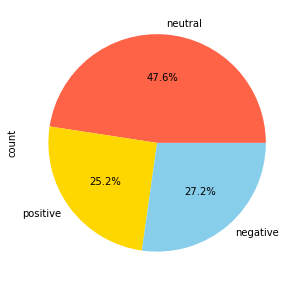

In [368]:
test = predictionFinal_mcu.groupBy('prediction').count()
test.show()
testdf = test.toPandas()
testdf.plot(legend=False, kind='pie', colors=['tomato', 'gold', 'skyblue'], figsize=(5,5), y='count', labels=labels, autopct='%1.1f%%')

In [369]:
char = predictionFinal_mcu.groupBy('character', 'prediction').count()
char.show(5)

+------------+----------+-----+
|   character|prediction|count|
+------------+----------+-----+
|JAMES RHODES|       1.0|   67|
|STEVE ROGERS|       0.0|  526|
|        THOR|       0.0|  410|
|  TONY STARK|       0.0|  799|
|PETER PARKER|       1.0|  147|
+------------+----------+-----+
only showing top 5 rows



In [370]:
df = char.toPandas()

In [371]:
newf = df.pivot(index='prediction', columns='character')
newf.columns = newf.columns.droplevel(0)
print(newf)

character   BRUCE BANNER  JAMES RHODES  LOKI  NATASHA ROMANOFF  NICK FURY  \
prediction                                                                  
0.0                  171           140   159               255        161   
1.0                   92            67    94               112        118   
2.0                  116           111    74               131         87   

character   PEPPER POTTS  PETER PARKER  STEVE ROGERS  THOR  TONY STARK  
prediction                                                              
0.0                  208           268           526   410         799  
1.0                  115           147           225   190         479  
2.0                  119           136           226   263         510  


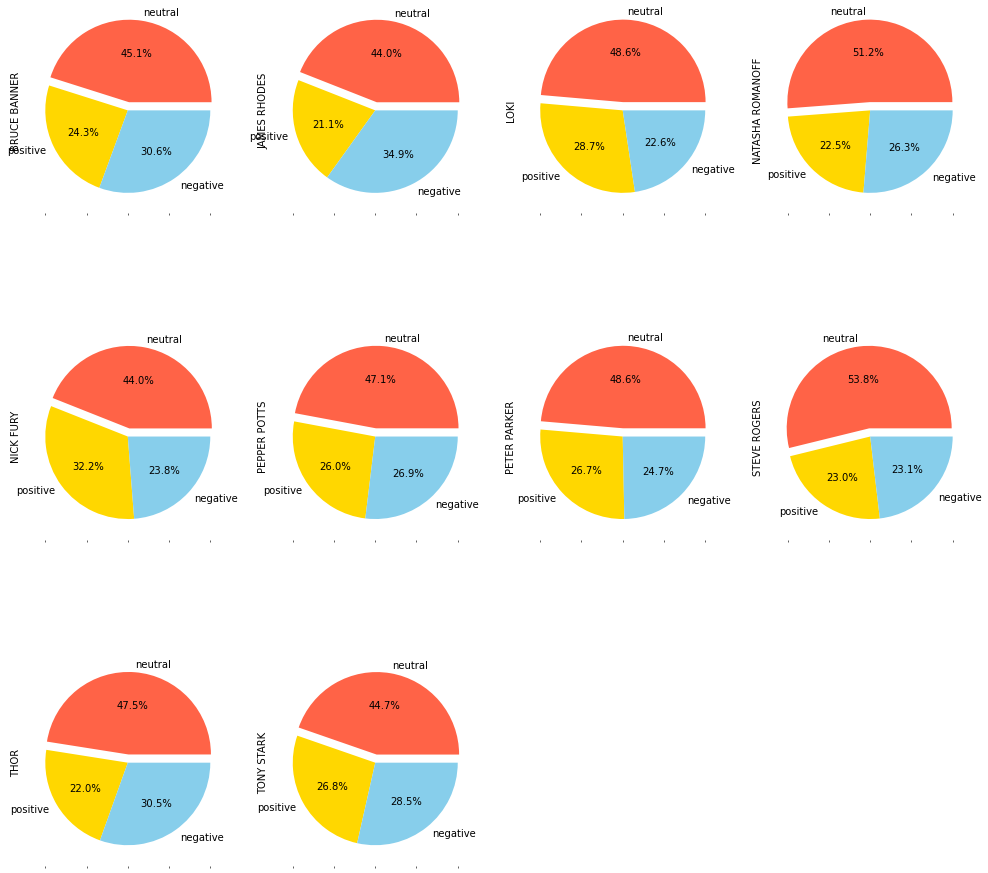

In [372]:

explodeTuple = (0.1,0,0)
char_pie = newf.plot(legend=False, labels=labels,explode=explodeTuple,kind='pie',subplots=True, colors=['tomato', 'gold', 'skyblue'], figsize=(17,17),layout=(3,4), autopct='%1.1f%%')

### What about the Vilains?

In [373]:

vilains = ['THANOS', 'N\'JADAKA (KILLMONGER)', 'RED SKULL', 'BUCKY BARNES', 'ULTRON', 'HELA', 'RONAN', 'ADRIAN TOOMES']
vil_csv = spark.read.csv('data/mcu.csv', inferSchema=True, header=True)
vilain_script = vil_csv.filter(F.col("character").isin(vilains)).select("character","line")
print('The most famous vilains have '+str(vilain_script.count())+'lines of dialogue')
vilain_script.show(n=600)

The most famous vilains have 544lines of dialogue
+--------------------+--------------------+
|           character|                line|
+--------------------+--------------------+
|           RED SKULL|It has taken me a...|
|           RED SKULL|No, of course. Bu...|
|           RED SKULL|Then why make suc...|
|           RED SKULL|No. But maybe you...|
|           RED SKULL|Exactly.  Gove th...|
|           RED SKULL|     I already have.|
|        BUCKY BARNES|Hey! Pick on some...|
|        BUCKY BARNES|How many times is...|
|        BUCKY BARNES|The one-o-seventh...|
|        BUCKY BARNES|Come on, man. My ...|
|        BUCKY BARNES|The future. I don...|
|        BUCKY BARNES|Good thing I took...|
|        BUCKY BARNES|Only the good stuff.|
|        BUCKY BARNES|           Holy cow.|
|        BUCKY BARNES|Hey, Steve, what ...|
|        BUCKY BARNES|Come on. You’re k...|
|        BUCKY BARNES|You’re really gon...|
|        BUCKY BARNES|As who? Steve fro...|
|        BUCKY BARNES|This

In [374]:
newt = Tokenizer(inputCol="line", outputCol="new_line")
swr_MCU = StopWordsRemover(inputCol=newt.getOutputCol(), 
                       outputCol="new", stopWords=stopwordList)

token_vilains_MCU = newt.transform(vilain_script)
nosw_vilains_MCU = swr_MCU.transform(token_vilains_MCU)
hash_vilains_MCU = hashTF.transform(nosw_vilains_MCU).select('character','new', 'features')

prediction_vilains_mcu = model.transform(hash_vilains_MCU)
prediction_vilains_mcu = prediction_vilains_mcu.select(
  'character', "new", "prediction")
prediction_vilains_mcu.show(n=5)

+---------+--------------------+----------+
|character|                 new|prediction|
+---------+--------------------+----------+
|RED SKULL|[taken, long, tim...|       2.0|
|RED SKULL|[no,, course., ot...|       1.0|
|RED SKULL|[make, effort, co...|       2.0|
|RED SKULL|[no., maybe, help...|       1.0|
|RED SKULL|[exactly., , gove...|       2.0|
+---------+--------------------+----------+
only showing top 5 rows



character   ADRIAN TOOMES  BUCKY BARNES  HELA  N'JADAKA (KILLMONGER)  \
prediction                                                             
0.0                    39            65     8                     32   
1.0                    41            28    10                     14   
2.0                    15            17    14                      7   

character   RED SKULL  RONAN  THANOS  ULTRON  
prediction                                    
0.0                18      5      46      39  
1.0                15      2      20      15  
2.0                22      2      43      27  


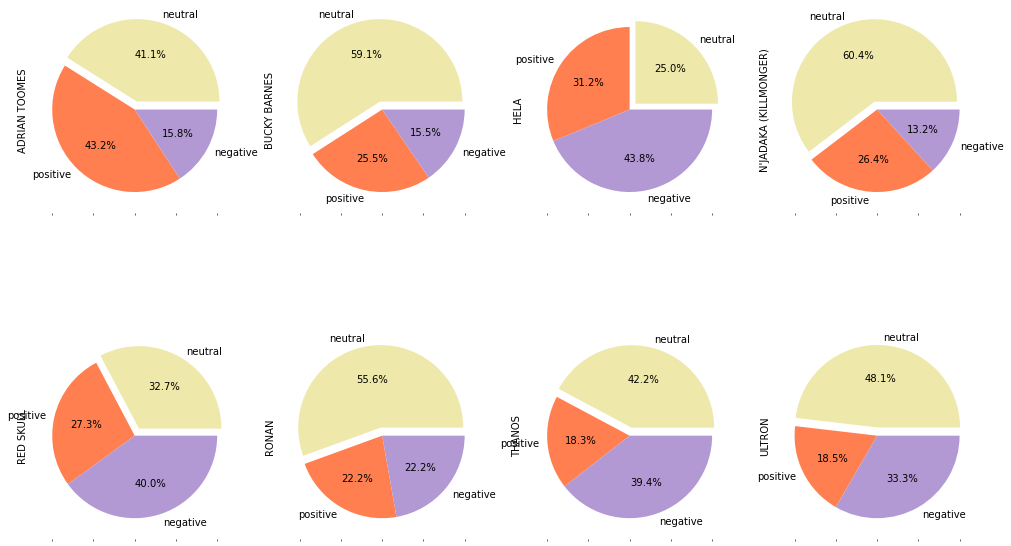

In [375]:
vil = prediction_vilains_mcu.groupBy('character', 'prediction').count()
vil = vil.toPandas()
newf = vil.pivot(index='prediction', columns='character')
newf.columns = newf.columns.droplevel(0)
print(newf)
char_pie = newf.plot(legend=False, labels=labels,explode=explodeTuple,kind='pie',subplots=True, colors=['palegoldenrod', 'coral', '#b399d4'], figsize=(17,17),layout=(3,4), autopct='%1.1f%%')

In [376]:
movie = predictionFinal_mcu.groupBy('movie', 'prediction').count()
filtered_movie = movie.filter(movie['count'] > 3)
filtered_movie.show(100)

+--------------------+----------+-----+
|               movie|prediction|count|
+--------------------+----------+-----+
|          Iron Man 2|       0.0|  299|
|      Captain Marvel|       0.0|   66|
|Captain America: ...|       2.0|   58|
|Captain America: ...|       1.0|  135|
|            Iron Man|       2.0|  200|
|Avengers: Age of ...|       2.0|  105|
|Captain America: ...|       1.0|  111|
|          Iron Man 3|       1.0|  123|
|Spider-Man: Homec...|       1.0|  155|
|Avengers: Infinit...|       1.0|  100|
|Thor: The Dark World|       0.0|  126|
|            Iron Man|       0.0|  153|
|Captain America: ...|       0.0|  192|
|      Captain Marvel|       1.0|   39|
|Avengers: Age of ...|       1.0|  155|
|   Avengers: Endgame|       1.0|   95|
|          Iron Man 3|       0.0|  291|
|Thor: The Dark World|       2.0|   53|
|        The Avengers|       1.0|  191|
|Thor: The Dark World|       1.0|   55|
|      Thor: Ragnarok|       1.0|   93|
|                Thor|       1.0|   58|


In [377]:
n = filtered_movie.toPandas()
new_movie = n.pivot(index='prediction', columns='movie')
new_movie.columns = new_movie.columns.droplevel(0)

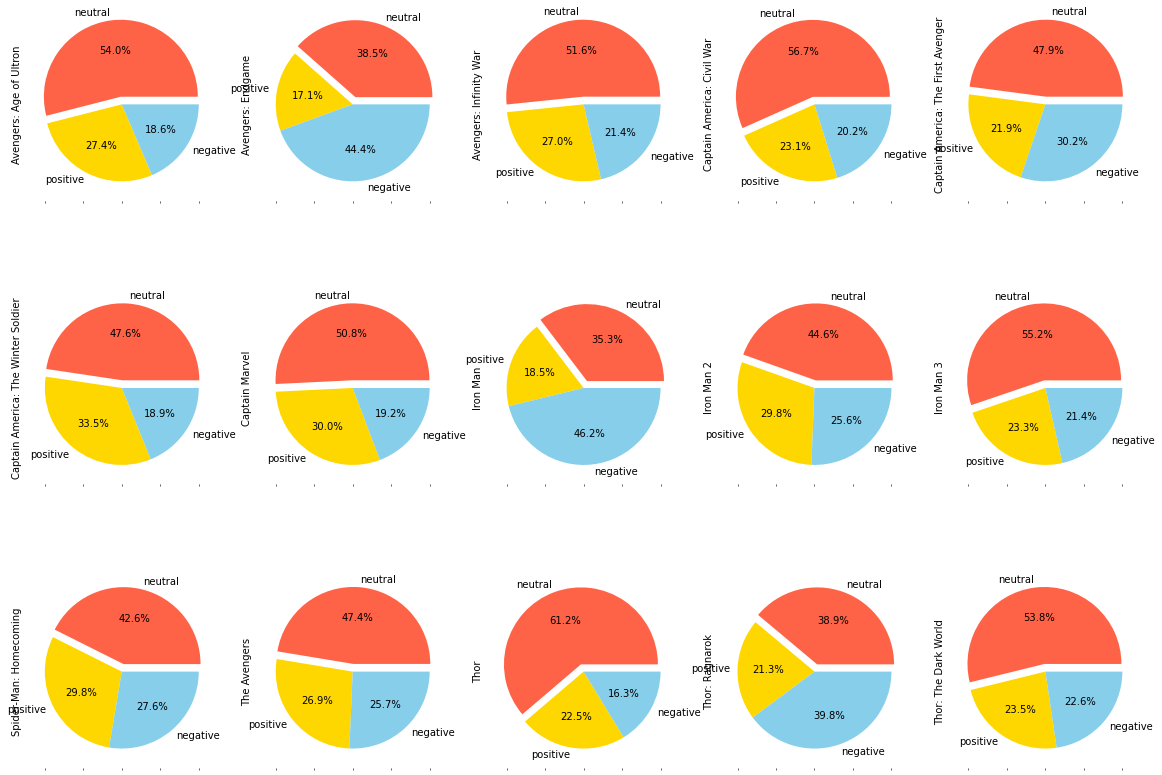

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61770)
Traceback (most recent call last):
  File "C:\Users\Ben\anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\Ben\anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\Ben\anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\Ben\anaconda3\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\Users\Ben\anaconda3\lib\site-packages\pyspark\accumulators.py", line 268, in handle
    poll(accum_updates)
  File "C:\Users\Ben\anaconda3\lib\site-packages\pyspark\accumulators.py", line 241, in poll
    if func():
  File "C:\Users\Ben\anaconda3\lib\site-packages\pyspark\accumulators.py", line 245, in accum_updates
    num_updates 

In [378]:

char_pie = new_movie.plot(labels=labels, explode=explodeTuple, legend=False,kind='pie',subplots=True, colors=['tomato', 'gold', 'skyblue'], figsize=(20,20),layout=(4,5), autopct='%1.1f%%')